# Exploratory Analysis in Pandas with Functions

How can we write clean code to organize messy analytical work?

Objectives:
1. Show how to break down a broad business problem into answerable data questions
2. Answer these questions in a diligent, clear, and reproducible way
3. Drive further exploration based on the answers to these questions

Number (2) above is where clean, effective Python code will save your ass

## The Business Problem: CRD Changes

An example of how a business partner might approach this, via **email**, **slack**, or **intake meeting**:

> We're facing a lot of uncertainty due to changing CRDs - it's difficult or impossible to arrange origin trucking, and some of our sailing/filght assignments are being invalidated. Can we get more visibility into how often this is happening? 

It pays to follow up with the stakeholder here to get some context and figure out how to best approach the problem:
1. What's the specific business risk involved? The first example above outlines this fairly well.
2. What are the specific scenarios where we might care about this?
3. How can this information be _actionable_ for the end user?

Number (3) is especially important here - ultimately, whatever solution that you provide, it should speak to some action that the stakeholder team can take based on the data.

Let's say you ask for clarification and get the following additional information:

> We're specifically interested in ocean shipments, because anecdotally it's really disrupting our fullillment process. If a CRD changes and we can't use the original assignment, then we might end up with dead inventory which has a pretty direct financial impact. It also creates a bad experience for the client, who may end up with a longer transit time.

> If we knew how often CRDs were historically changing, we could get a sense of how much this is contributing to our overall fulfillment problems. We can start to "score" clients based on the likelihood that their CRDs will change, and either enforce better behavior or account for this in our fulfillment process. It would be really cool to actually _anticipate_ which CRDs will change and by how much, anecdotally this seems really unpredictable.

## Framing Analytical Questions

Great - now we have a better understanding of how the business is thinking about this problem. But where do we even start with actually pulling data?

While some of the suggestions from our stakeholder might be exciting - predicting CRD changes, scoring clients - here it pays to ***challenge your assumptions, start as simple as possible, and increase complexity in a logical and incremental fashion***

We can start by laying out some clearly defined questions that we should be able to answer with data:
- How often do shipment CRDs change?
- When CRD does change, how much on average does it differ from the original or previous CRD?
- When do CRD changes typically occur, relative to quoting and relative to the CRD itself?

All of these should give us insight into the more general questions asked by our stakeholder (how much of a problem is this?) while also giving us a sense of how much further we can take this analysis. All of these questions can also be sliced on different dimensions, like client segment and trade-lane, to get more insight (if it's actionable).

***What data points would we need to answer these basic questions?***
- Each instance of a CRD being created or changed for a shipment
- The time that the creation/change took place
- The CRD at that time
- When the shipment was quoted

Unfortunately we don't have a true event-based data table for CRDs (if this has changed, awesome). But we _can_ back out the changes from the audits table. Let's grab the data and get started.

In [101]:
import pandas as pd
import numpy as np
from datetime import date

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (11,6)
%config IPCompleter.greedy=True


### Installing internal packages
We'll want to use our internal Python library to access Snowflake. It's easy to install!

Check out [PyPi instructions here](https://github.flexport.io/flexport/kimono/tree/master/astronomer/commonlib#step-6-installing-your-package) and navigate the [PyPi server here](http://10.70.168.13:6543/#/)

In [149]:
!pip3 install -i http://10.70.168.13:6543/simple/ analytics-utils==1.1.4 --trusted-host 10.70.168.13
from analytics_utils.utils import snowflake as sf

Looking in indexes: http://10.70.168.13:6543/simple/


### Start with a query

The data has to come from somewhere...

Some general notes on SQL queries as part of EDA workflow:
- Code structure
    - You can extract the query into a separate file, but I like keeping it in the notebook so things are self contained and easier to reference
    - I like defining the query as a standalone string that you can reference in a function. That way, you can edit the query separately from running it
- How to write the query
    - Avoid including too much complex logic/transformation in the query itself. Python code is generally easier to parse and understand what's going on (maybe just my opinion)
    - We also want to avoid having to re-run the query a million times
    - "Go wide" and include any data that you think you might need



In [88]:
# here I define my query as a string

CRD_CHANGE_QUERY = (
    """
    SELECT 
      a.id as audit_id,
      a.auditable_id as leg_id,
      a.action,
      sl.shipment_id,
      a.created_at as changed_at,
      CASE WHEN ARRAY_SIZE(a.audited_changes:cargo_ready_date) = 2
        THEN a.audited_changes:cargo_ready_date[1]
        ELSE a.audited_changes:cargo_ready_date END as crd,
      q.quote_submitted_at,
      q.quote_accepted_at
    FROM core.audits as a
       JOIN legacy.bi_shipment_legs as sl
       ON (a.auditable_id = sl.leg_id 
           AND a.auditable_type in ('OperationalRoute::Leg', 'Leg')
           AND sl.from_origin_address)
       JOIN legacy.prep_quotes as q
       ON (sl.shipment_id = q.shipment_id and q.quote_accepted_at is not null)
    WHERE
      a.audited_changes:cargo_ready_date is not null
      AND a.audited_changes:cargo_ready_date != 'null'
      AND a.created_at BETWEEN '{start}' and '{end}'
    """)


# notice the bits in curly braces - these are arguments that we will later *interpolate* into the query

In [19]:
# next, I want to define a function to run a query with arguments
#  using a function here isolates the code necessary to pull data, so it's super easy to call later on

# first, let's set up a blank function
#  there's a lot of stuff here, but it doesn't actually do anything
def get_crd_changes(start: date, end: date) -> pd.DataFrame:
    """
    Return every instance of a CRD changing during the period between ``start`` and ``end``
    Pulling from the audits table
    """
    pass # we can use "pass" to have the function do nothing. 
         # This is a good way to skeleton out the work that you want to do

### Anatomy of a function

1. Name: make it descriptive, even if it's verbose
2. Arguments: act as variables within the function. Here, we can put key pieces of configuration that we might want to change
    - Example: adding start and end dates to our query. Instead of changing the query itself, we can define arguments that are *interpolated* into the query text
3. Return something - in this case, a DataFrame

#### A note on type hints
You may notice the **type hints** above. This is a new feature in Python 3 that allows us to specify input and output types. Each argument has a type, indicated with `:`, while the type of the data returned by the function is indicated outside of the function with `->`

Type hints are not required, nor are they enforced. Check it out below:

In [132]:
# define a function to add two... things of unspecified type
def my_function(a, b):
    return a + b

In [136]:
# What will this return?
#my_function(1, 2)

In [137]:
# What will this return?
#my_function('a', 'b')

In [138]:
# What will this return?
#my_function('a', 1)

In [140]:
# let's rewrite this with type hints
def my_function_with_hints(a: int, b: int) -> int:
    return a + b

In [142]:
# However, does this actually do anything?
#my_function_with_hints('a', 'b')

#### Why bother with type hints anyway?

Type hints act as *rich documentation* of a function's intended usage. If you're collaborating with someone, or revisiting old code, you can quickly understand what to expect. Sure, it's not enforced, but it is helpful.

We most often see type hints in *production-level code*, where style guidelines may require their usage. So, is there any value in using them for ad-hoc analysis in notebooks, or is this just Tyler being a hardass (who has written production code)?

My *opinion* is emphatically yes! For all the reasons above, using type hints helps us write clean, well documented code without much additional effort. It also forces us to write functions with clear usage and avoid any unpleasant type flexibility that may be allowed by Python.

#### A note on *docstrings*

After the function definitions, you can include documentation using triple quotes. This is referred to as a "docstring" and acts as another key piece of documentation around functions. Again, these are typically required as part of style guidelines for production code - but, they can be useful for analytical work as well.

What should the docstring contain?
- A *concise* explanation of what the function does. If you can't concisely explain, it's likely that the function is doing too much!
- Explanation for how each of the arguments of a function are used 
- Explanation for the data returned

In [21]:
# time to actually write the function
def get_crd_changes(start: date, end: date) -> pd.DataFrame:
    """
    Return every instance of a CRD changing during the period between ``start`` and ``end``
    Pulling from the audits table
    """
    # interpolate arguments into the query
    formatted_query = CRD_CHANGE_QUERY.format(start=start, end=end)
    
    # use our snowflake package to run the query
    return sf.run_snowflake_query(formatted_query)

In [145]:
# `.format()` "just works" with dates, but let's make sure...
'{start}'.format(start=date(2020,1,1))

'2020-01-01'

In [146]:
# use our function
# our use of arguments comes in handy here
#   we can run with a shorter date range to confirm that this is working
#   without waiting forever
crd_changes = get_crd_changes(date(2020, 1, 1), date(2021, 1, 1))

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


### Sanity checking the data

Prior to making any assertions, let's make sure that things look OK from a high level

- Is the _grain_ what I expected? 
    - It's a good practice to include some kind of primary key in your query, just so this is easier to reason about
    - the `.value_counts()` method is a lifesaver here
- Do columns take on the values that I expected?
    - Is anything missing more often than I would expect?
- Is the size in line with what I would expect (orders of magnitude)
- Other specific pieces of logic that might make sense

In [90]:
# is the grain correct?
crd_changes.audit_id.value_counts().head()

f864cd55-8ee7-4756-84f7-85907f2a0baf    1
b26278ab-5e0c-4173-b78b-f960089c4104    1
12e91549-5213-40f9-a260-6e5964e7b438    1
21ccd5ba-e169-41c4-81fa-8d48ad3fef05    1
17811eef-ec03-436c-b07d-21e806ddada9    1
Name: audit_id, dtype: int64

In [91]:
# does everything look as expected?
crd_changes.sample(5)

,audit_id,leg_id,action,shipment_id,changed_at,crd,quote_submitted_at,quote_accepted_at
29718,4021651a-6402-4a75-a0da-0566eeba5c5a,7562673,update,828236,2020-07-01 03:14:19.313000+00:00,"""2020-07-20""",2020-06-30 01:21:15.366435,2020-06-30 16:58:25.993621
381389,780a58af-ce6c-4717-a015-d024fb623ce7,6817051,update,705724,2020-03-31 15:53:32.779000+00:00,"""2020-04-16""",2020-04-14 10:35:22.443708,2020-04-14 10:35:22.654336
241588,2d903734-7fe4-4ceb-ba2e-cd5bf31ad061,8292224,create,895207,2020-09-08 21:44:54.188000+00:00,"""2020-10-06""",2020-11-13 17:29:33.680335,2020-11-13 17:47:50.474152
93678,45a71656-5e2a-4cae-98dd-5b04f244d577,8292138,create,899187,2020-09-08 21:33:49.992000+00:00,"""2020-09-07""",2020-09-08 21:33:15.029815,2020-09-08 21:33:43.859163
332073,c2f4c863-4fb8-4943-9f5c-15d9b89d05be,6701363,create,740847,2020-03-14 01:42:47.400000+00:00,"""2020-03-16""",2020-03-09 16:48:39.815871,2020-03-14 01:42:39.009066


In [122]:
# the CRD field is a bit funky, let's deal with that
crd_changes['crd'] = pd.to_datetime(crd_changes.crd.str.strip('"'), errors='coerce')

In [123]:
# are the types correct?
crd_changes.dtypes

audit_id                           object
leg_id                              int64
action                             object
shipment_id                         int64
changed_at            datetime64[ns, UTC]
crd                        datetime64[ns]
quote_submitted_at         datetime64[ns]
quote_accepted_at          datetime64[ns]
dtype: object

In [92]:
# is anything missing more often than we expect?
pd.isnull(crd_changes).mean()

audit_id              0.000000
leg_id                0.000000
action                0.000000
shipment_id           0.000000
changed_at            0.000000
crd                   0.000000
quote_submitted_at    0.000003
quote_accepted_at     0.000000
dtype: float64

In [93]:
# how much data was returned?
crd_changes.shape

(390190, 8)

In [94]:
# how does this compare to the number of shipments?
crd_changes.shipment_id.nunique()

205491

### Let's start actually answering our questions

First, ***how often do shipment CRDs change?***

Let's think of ways to summarize this

In [97]:
# what percentage of legs have more than one CRD? 
leg_crd_counts = crd_changes.groupby('leg_id')['audit_id'].count()
(leg_crd_counts > 1).mean()

0.19276457009282252

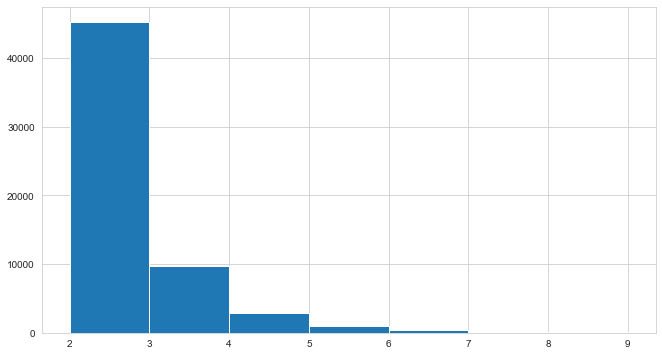

In [103]:
# how often do CRDs change more than once?
leg_crd_counts.loc[leg_crd_counts > 1].hist(bins=np.arange(2, 10, 1))

In [107]:
(leg_crd_counts.value_counts() / len(leg_crd_counts)).head(6)

1    0.807235
2    0.146450
3    0.031622
4    0.009431
5    0.003157
6    0.001191
Name: audit_id, dtype: float64

**When CRD does change, how much on average does it differ from the original or previous CRD?**

In [131]:
# here, we need to do some additional transformation
first_crd = crd_changes.sort_values('changed_at').groupby('leg_id')[['crd', 'changed_at']].first()

crd_comparison = crd_changes.copy()
crd_comparison['previous_crd'] = crd_changes.sort_values('changed_at').groupby('leg_id').crd.shift(1)
crd_comparison = crd_comparison.set_index('leg_id').join(first_crd, how='inner', rsuffix='_first').reset_index()

# now generate columns to indicate difference
crd_comparison['difference_from_prev'] = (crd_comparison.crd - crd_comparison.previous_crd) / np.timedelta64(1, 'D')
crd_comparison['difference_from_first'] = (crd_comparison.crd - crd_comparison.crd_first) / np.timedelta64(1, 'D')

# I want my difference to be null in cases when it's the first CRD
crd_comparison.loc[crd_comparison.changed_at == crd_comparison.changed_at_first, 'difference_from_first'] = np.nan
crd_comparison.head()

,leg_id,audit_id,action,shipment_id,changed_at,crd,quote_submitted_at,quote_accepted_at,previous_crd,crd_first,changed_at_first,difference_from_prev,difference_from_first
0,3746888,3bc8b048-952c-4228-baeb-96b27e1fc41c,update,464990,2020-01-03 09:08:57.387000+00:00,2018-09-19,2018-12-18 03:39:54.475116,2018-12-18 03:40:08.736630,NaT,2018-09-19,2020-01-03 09:08:57.387000+00:00,NaN,NaN
1,3747026,4475bb3f-cf8e-429d-a635-ea0c315512dc,update,465006,2020-01-03 09:10:07.185000+00:00,2018-09-21,2018-12-18 03:55:55.994154,2018-12-18 04:00:12.506836,NaT,2018-09-21,2020-01-03 09:10:07.185000+00:00,NaN,NaN
2,3755836,118cc2d4-b045-4c73-879a-1bdf14f2eb11,update,466004,2020-01-03 09:10:38.638000+00:00,2018-10-10,2019-01-17 11:04:49.781597,2019-01-17 11:06:10.277585,NaT,2018-10-10,2020-01-03 09:10:38.638000+00:00,NaN,NaN
3,3755944,55e71d31-628e-45c5-91b5-e92d11749266,update,466009,2020-01-03 09:11:00.860000+00:00,2018-10-14,2018-12-19 09:25:42.322081,2018-12-19 09:25:51.627186,NaT,2018-10-14,2020-01-03 09:11:00.860000+00:00,NaN,NaN
4,3756929,1c8127d7-d21d-4f88-bf71-7dd7f6b13193,update,466013,2020-01-03 09:11:20.273000+00:00,2018-10-17,2018-12-19 09:56:18.845739,2018-12-19 12:53:06.579606,NaT,2018-10-17,2020-01-03 09:11:20.273000+00:00,NaN,NaN
